# Automation of Human Karyotype Analysis Using Image Segmentation and Classification Methods. Pipeline.

## Imports

In [ ]:
!pip install ultralytics

In [ ]:
import os
import xml.etree.ElementTree as ET
import torch
from torchvision import transforms, models
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from ultralytics import YOLO
import math
from collections import defaultdict
from matplotlib import gridspec

## Pipeline

In [ ]:
def parse_voc_xml(xml_file):
    """Parses XMl files"""
    tree = ET.parse(xml_file)
    root = tree.getroot()
    gt_boxes = []
    gt_labels = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        gt_boxes.append([xmin, ymin, xmax, ymax])
        gt_labels.append(label)
    return gt_boxes, gt_labels

def classify_chromosome_from_image(model, image, transform, device, class_names):
    """Classify chromosomes in cropped images"""
    model.eval()
    img_t = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_t)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]
    return predicted_class

def detect_and_classify(image, det_model, cls_model, transform, device, class_names):
    """Function that segment and classify objects"""
    results = det_model(image)
    result = results[0]
    pred_boxes = result.boxes.xyxy.cpu().numpy()
    pred_labels = []

    for box in pred_boxes:
        xmin, ymin, xmax, ymax = box.astype(int)
        cropped = image.crop((xmin, ymin, xmax, ymax))
        pred_label = classify_chromosome_from_image(cls_model, cropped, transform, device, class_names)
        pred_labels.append(pred_label)
    return pred_boxes, pred_labels

In [ ]:
def draw_boxes(image, boxes, labels, box_color, font=None, text_bg_color='white', padding=2):
    """Draw boxes with labels"""
    draw = ImageDraw.Draw(image)
    if font is None:
        font = ImageFont.load_default(size=14)

    for (xmin, ymin, xmax, ymax), label in zip(boxes, labels):
        draw.rectangle([xmin, ymin, xmax, ymax], outline=box_color, width=2)

        left, top, right, bottom = draw.textbbox((xmin, ymin), label, font=font)
        bg_box = [
            left - padding,
            top - padding,
            right + padding,
            bottom + padding
        ]
        draw.rectangle(bg_box, fill=text_bg_color)
        draw.text((xmin, ymin), label, fill=box_color, font=font)

    return image

def plot_results(image, gt_boxes, gt_labels, pred_boxes, pred_labels):
    """Ploting results of segmentation and classification"""
    pred_boxes_int = [list(map(int, box)) for box in pred_boxes]
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    image_gt = image.copy()
    image_gt = draw_boxes(image_gt, gt_boxes, gt_labels, box_color='green')
    axes[0].imshow(image_gt)
    axes[0].set_title("Ground Truth")
    axes[0].axis("off")

    image_pred = image.copy()
    image_pred = draw_boxes(image_pred, pred_boxes_int, pred_labels, box_color='red')
    axes[1].imshow(image_pred)
    axes[1].set_title("Predictions")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

def plot_karyotype_rows(image, pred_boxes, pred_labels, row_layout=[5,7,6,5], pad_color=(255,255,255),
                        hspace=0.4, wspace=0.3, title_fontsize=8):
    auto_groups = defaultdict(list)
    last_pair = []
    for box, lbl in zip(pred_boxes, pred_labels):
        if lbl in ("X","Y"):
            last_pair.append((box, lbl))
        else:
            auto_groups[lbl].append(box)

    groups = dict(auto_groups)
    if last_pair:
        lasp_pair_sorted = sorted(last_pair, key=lambda x: x[1])
        last_pair_boxes, last_pair_lbls = zip(*lasp_pair_sorted)
        last_pair_key = "".join(last_pair_lbls)
        groups[last_pair_key] = list(last_pair_boxes)

    def sort_key(lbl):
        nums = ''.join(filter(str.isdigit, lbl))
        return (int(nums) if nums else 999, lbl)
    class_keys = sorted(groups.keys(), key=sort_key)

    stitched = []
    for key in class_keys:
        crops = []
        for box in groups[key]:
            xmin,ymin,xmax,ymax = map(int, box)
            crops.append(image.crop((xmin,ymin,xmax,ymax)))
        widths, heights = zip(*(c.size for c in crops))
        total_w, max_h = sum(widths), max(heights)
        canvas = Image.new("RGB", (total_w, max_h), pad_color)
        x_off = 0
        for c in crops:
            canvas.paste(c, (x_off, 0))
            x_off += c.width
        stitched.append((key, canvas))

    n_rows = len(row_layout)
    fig = plt.figure(figsize=(max(row_layout)*2, n_rows*2), tight_layout=False)
    outer = gridspec.GridSpec(n_rows, 1, figure=fig, hspace=hspace)

    idx = 0
    for r, n_cols in enumerate(row_layout):
        inner = gridspec.GridSpecFromSubplotSpec(1, n_cols, subplot_spec=outer[r], wspace=wspace)
        for c in range(n_cols):
            if idx >= len(stitched):
                break
            key, im = stitched[idx]
            ax = fig.add_subplot(inner[c])
            ax.imshow(im)
            ax.set_title(key, fontsize=title_fontsize)
            ax.axis("off")
            idx += 1

    plt.tight_layout()
    plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

class_names = [
    'A1', 'A2', 'A3', 'B4', 'B5', 'C10', 'C11', 'C12', 'C6', 'C7', 'C8', 'C9',
    'D13', 'D14', 'D15', 'E16', 'E17', 'E18', 'F19', 'F20', 'G21', 'G22', 'X', 'Y'
]

classification_model = models.mobilenet_v2()
in_features = classification_model.classifier[1].in_features
classification_model.classifier[1] = torch.nn.Linear(in_features, len(class_names))
classification_model.load_state_dict(torch.load("MobileNetV2_pretrained.pth", map_location=device))
classification_model.to(device)

det_model_path = "best.pt"
det_model = YOLO(det_model_path)

## Results


0: 640x608 46 chromosomess, 2673.4ms
Speed: 5.3ms preprocess, 2673.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 608)


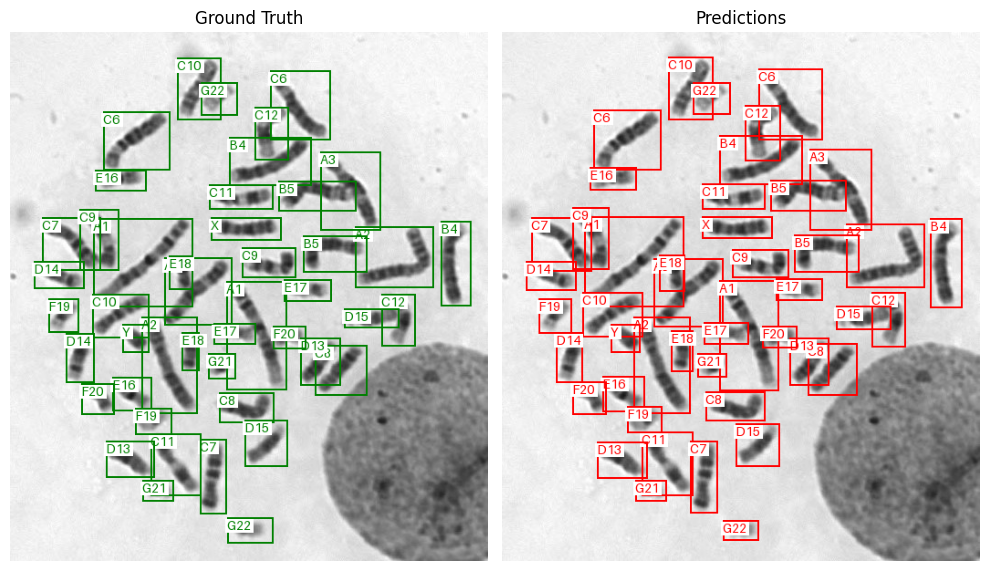

<ipython-input-45-21b81b03b25f>:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


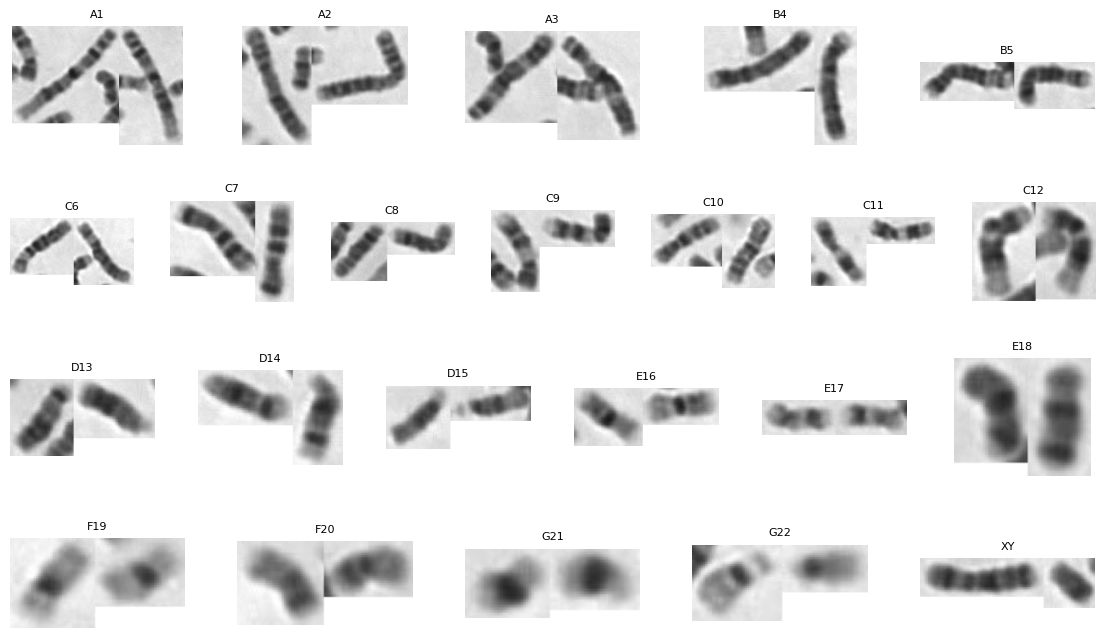

In [ ]:
image_filename = "103064.jpg"
xml_file = "103064.xml"

gt_boxes, gt_labels = parse_voc_xml(xml_file)
image = Image.open(image_filename).convert('RGB')

pred_boxes, pred_labels = detect_and_classify(image, det_model, classification_model, transform, device, class_names)

plot_results(image, gt_boxes, gt_labels, pred_boxes, pred_labels)
plot_karyotype_rows(image, pred_boxes, pred_labels)


0: 608x640 47 chromosomess, 2576.4ms
Speed: 11.1ms preprocess, 2576.4ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


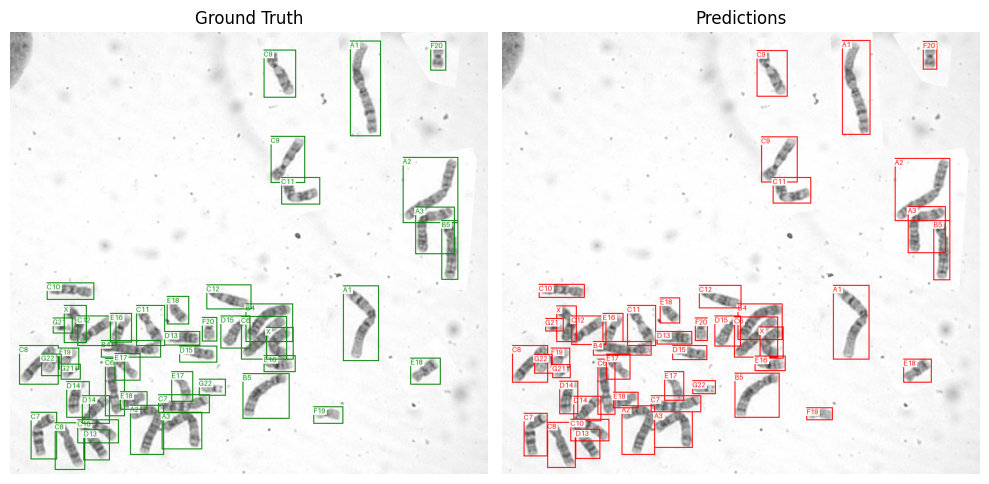

<ipython-input-45-21b81b03b25f>:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


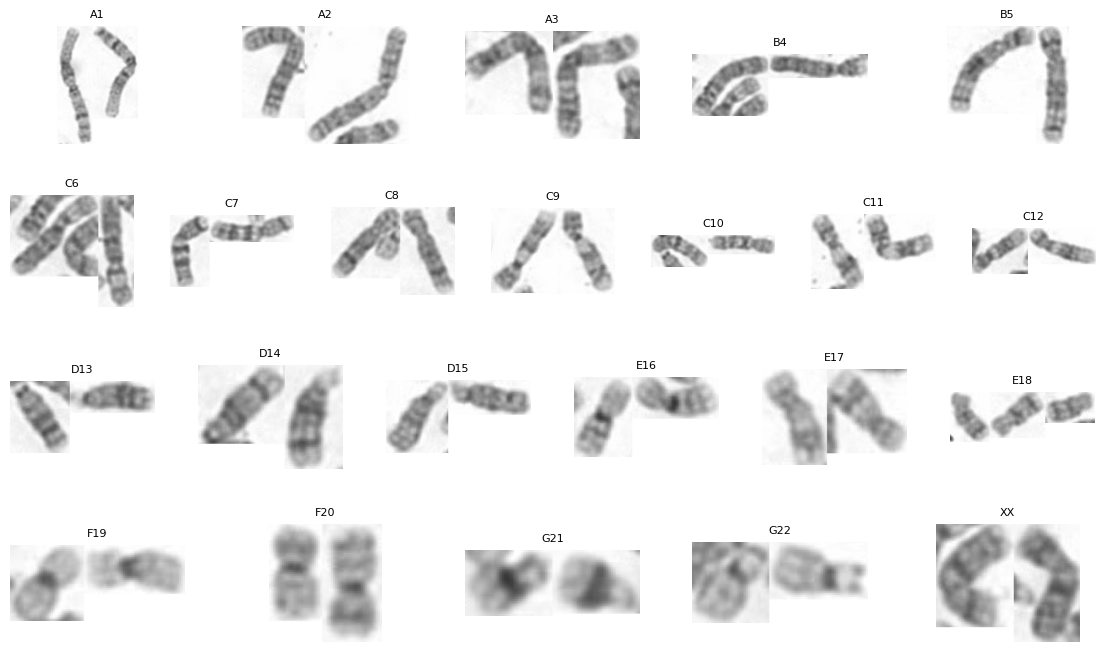

In [ ]:
image_filename = "1050431.jpg"
xml_file = "1050431.xml"

gt_boxes, gt_labels = parse_voc_xml(xml_file)
image = Image.open(image_filename).convert('RGB')

pred_boxes, pred_labels = detect_and_classify(image, det_model, classification_model, transform, device, class_names)

plot_results(image, gt_boxes, gt_labels, pred_boxes, pred_labels)
plot_karyotype_rows(image, pred_boxes, pred_labels)
